## Recommendation engine application on movie lens data

In [1]:
# https://grouplens.org/datasets/movielens/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ratings = pd.read_csv('../dataset/ml-latest-small/ml-latest-small/ratings.csv')

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movies = pd.read_csv('../dataset/ml-latest-small/ml-latest-small/movies.csv')

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Combining movie ratings & movie names
ratings = pd.merge(ratings[['userId', 'movieId', 'rating']], 
                  movies[['movieId', 'title']], how='left', left_on='movieId', right_on='movieId')

In [8]:
ratings.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,1,1029,3.0,Dumbo (1941)
2,1,1061,3.0,Sleepers (1996)
3,1,1129,2.0,Escape from New York (1981)
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989)


The following code converts the data into a matrix form where rows are unique user IDs
and columns are unique movie IDs, and the values in the matrix are ratings provided by
users. This matrix is majorly sparse in nature, hence we are replacing NAN values with
zeros to enable calculations. The entire computation in later sections of the code is based on
this matrix:

In [22]:
rp = ratings.pivot_table(columns = ['movieId'], index=['userId'], values='rating')
rp = rp.fillna(0)

A pandas DataFrame is built on top of a NumPy array, hence it would be advisable to use a
NumPy array instead of a pandas DataFrame; a little conversion like this saves huge
computational overheads while calculating a user-user similarity matrix or item-item
similarity matrix.

In [23]:
# Converting pandas DataFrame to Numpy for faster execution in loops etc
rp_mat = rp.as_matrix()

In [24]:
type(rp_mat)

numpy.ndarray

Sample cosine similarity is illustrated with the following code for dummy values. But, the
methodology remains the same for content-based filtering:

In [25]:
from scipy.spatial.distance import cosine
# The consine of the angle between them is about 0.822.
a = np.asarray([2, 1, 0, 2, 0, 1, 1, 1])
b = np.asarray([2, 1, 1, 1, 1, 0, 1, 1])
print('Cosine similarity between A and B is %0.4f' % (1-cosine(a,b)))

Cosine similarity between A and B is 0.8216


### User-user similarity matrix

The following code illustrates user-user similarity matrix computation based on complete
brute force calculations (using a for loop inside another for loop with time complexity of
On2). There are many other efficient methods to compute the same, but for ease of
understanding for readers, here we have provided one that is as simple as possible:

In [53]:
range(m)

range(0, 671)

In [26]:
m, n = rp.shape
# User similarity matrix
mat_users = np.zeros((m, m))

for i in range(m):
    for j in range(m):
        if i != j:
            mat_users[i][j] = (1 - cosine(rp_mat[i, :], rp_mat[j, :]))
        else:
            mat_users[i][j] = 0
pd_users = pd.DataFrame(mat_users, index=rp.index, columns=rp.index)

The following custom function takes any user ID and the number of similar users to be
displayed as an input and returns the similar users according to their relevant cosine
similarity score:

In [57]:
# Finding similar users
def topn_simuusers(uid=16, n=5):
    users = pd_users.loc[uid, :].sort_values(ascending=False)
    topn_users = users.iloc[:n,]
    topn_users = topn_users.rename('score')
    print('Similar users as user:', uid)
    return pd.DataFrame(topn_users)
print(topn_simuusers(uid=17, n=10))

Similar users as user: 17
           score
userId          
596     0.379128
23      0.374641
355     0.329605
430     0.328872
608     0.319770
509     0.319313
105     0.309477
457     0.308201
15      0.307179
461     0.299035


Our task is not complete by just looking into the similar users themselves; rather, we would
like to see what the most highly rated movies of any particular user are too. The following
function provides that information for any given user and their most preferred movies:

In [60]:
# Finding most rated movies of a user
def topn_movieratings(uid = 355, n_ratings=10):
    uid_ratings = ratings.loc[ratings['userId'] == uid]
    uid_ratings = uid_ratings.sort_values(by='rating', ascending=[False])
    print('Top', n_ratings, 'movie ratings of user:', uid)
    return uid_ratings.iloc[:n_ratings,]
print(topn_movieratings(uid=596, n_ratings=10))

Top 10 movie ratings of user: 596
       userId  movieId  rating                                   title
89645     596     4262     5.0                         Scarface (1983)
89732     596     6874     5.0                Kill Bill: Vol. 1 (2003)
89353     596      194     5.0                            Smoke (1995)
89546     596     2329     5.0               American History X (1998)
89453     596     1193     5.0  One Flew Over the Cuckoo's Nest (1975)
89751     596     8132     5.0                        Gladiator (1992)
89579     596     2858     5.0                  American Beauty (1999)
89365     596      296     5.0                     Pulp Fiction (1994)
89587     596     2959     5.0                       Fight Club (1999)
89368     596      318     5.0        Shawshank Redemption, The (1994)


The following screenshot displays the most rated movies of user 596 and their titles so that
we will get an idea which movies that particular user rated most highly:

### Movie-movie similarity matrix

Previous sections of the code discussed content-based user-user similarity, whereas in the
following section, we will be talking about a pure movie-movie similarity relation matrix,
so that we will mine a bit deeper into how close each movie is to other movies.

In the following code, time functions are utilized for computing the movie-movie similarity
matrix. It took a good 30 minutes on my i7 computer. It may take even more time on
moderate computers, hence I have stored the output result and read back for convenience;
readers are encouraged to run it and check for themselves though:

In [62]:
np.zeros((n, n)).shape

(9066, 9066)

In [64]:
rp[:2]

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Movie similarity matrix
import time
start_time = time.time()
mat_movies = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            mat_movies[i, j] = (1 - cosine(rp_mat[:, i], rp_mat[:, j]))
        else:
            mat_movies[i, j] = 0
print("--- %s seconds ---" % (time.time() - start_time))

pd_movies = pd.DataFrame(mat_movies, index = rp.columns, columns = rp.columns)

--- 2916.9139189720154 seconds ---


In [67]:
pd_movies.to_csv('pd_movies.csv', sep=',')
pd_movies = pd.read_csv('pd_movies.csv', index_col='movieId')

In [68]:
pd_movies.shape

(9066, 9066)

In [69]:
pd_movies[:2]

,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,0.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000


In [70]:
# Finding similar movies
def topn_simovies(mid = 588, n = 15):
    mid_ratings = pd_movies.loc[mid, :].sort_values(ascending=False)
    topn_movies = pd.DataFrame(mid_ratings.iloc[:n,])
    topn_movies['index1'] = topn_movies.index
    topn_movies['index1'] = topn_movies['index1'].astype('int64')
    topn_movies = pd.merge(topn_movies, movies[['movieId', 'title']],
                          how='left', left_on='index1', right_on='movieId')
    print('Movies simlar to movie id:', mid, ',', 
          movies['title'][movies['movieId'] == mid].to_string(index=False), ',are')
    del topn_movies['index1']
    return topn_movies

print(topn_simovies(mid=589, n=15))

Movies simlar to movie id: 589 , Terminator 2: Judgment Day (1991) ,are
         589  movieId                                              title
0   0.702256      480                               Jurassic Park (1993)
1   0.636392     1240                             Terminator, The (1984)
2   0.633428      110                                  Braveheart (1995)
3   0.619415      356                                Forrest Gump (1994)
4   0.614814      377                                       Speed (1994)
5   0.605887      380                                   True Lies (1994)
6   0.604555      457                               Fugitive, The (1993)
7   0.591071      593                   Silence of the Lambs, The (1991)
8   0.579325      367                                   Mask, The (1994)
9   0.577299     1036                                    Die Hard (1988)
10  0.576275      592                                      Batman (1989)
11  0.568341      296                               

After carefully examining the following results, the movies which are similar to
Terminator 2 are Jurassic Park, Terminator, The, Braveheart, Forrest Gump,
Speed, and so on; all these movies fall under the action category actually. The results seem
to be sound enough for me to select my next movie to watch from this analysis! Contentbased
filtering seems to be working!

### Collaborative filtering using ALS

In [127]:
rating = pd.read_csv('../dataset/ml-latest-small/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,1,1029,3.0,Dumbo (1941)
2,1,1061,3.0,Sleepers (1996)
3,1,1129,2.0,Escape from New York (1981)
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [128]:
movies = pd.read_csv('../dataset/ml-latest-small/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [129]:
rp = ratings.pivot_table(columns=['movieId'], index=['userId'], values='rating')
rp = rp.fillna(0)

In [130]:
A = rp.values
print('\nShape of Original Sparse Matrix', A.shape)


Shape of Original Sparse Matrix (671, 9066)


The following W matrix actually has the same dimension as the original ratings matrix
(matrix A) but only has values of 0 or 1 whenever a user provided a rating to any movie
(minimum valid rating for any movie is 0.5, with the maximum rating as 5); we needed this
type of matrix in calculating errors and so on (we will see its application in a later section of
the code) as this way is more convenient to minimize the errors:

In [131]:
W = A > 0.5
W[W == True] = 1
W[W == False] = 0
W = W.astype(np.float64, copy=False)

In [132]:
A[-1] > 0.5

array([ True, False, False, ..., False, False, False])

Similarly, another matrix, W_pred, is also needed to provide recommendations. The W_pred
matrix has values of 0 or 1, exactly opposite to the W matrix. The reason for this is, if we
multiply the predicted rating matrix with this W_pred matrix, this will make all values 0 for
already provided ratings, so that other non-reviewed/non-rated values can be easily put in
descending order and suggest the top 5 or 10 movies to the user who has never rated/seen
those movies. If you observe carefully, here we are assigned zeros to all diagonal elements
too, as we should not recommend the same movie as the most probable movie to users,
which is sensible:

In [133]:
W_pred = A < 0.5
W_pred[W_pred == True] = 1
W_pred[W_pred == False] = 0
W_pred = W_pred.astype(np.float64, copy=False)
np.fill_diagonal(W_pred, val=0)

Hyperparameters are initiated in the following code with sample values, the number of
iterations is set to 200, the number of latent factors is set to 100 with learning rate as 0.1:

In [134]:
# Parameters
m, n = A.shape
n_iterations = 200
n_factors = 100
lmbda = 0.1

The X and Y values are initiated with random numbers from uniform distribution [0-1] and
multiplied by 5 for converting between 0 and 5. The number of dimensions for X and Y is (m
x k) and (k x n) respectively, as we will start with a random value and optimize step by step
for each iteration:

In [135]:
X = 5 * np.random.rand(m, n_factors)
Y = 5 * np.random.rand(n_factors, n)

RMSE values are calculated with the following formulas. Here, we are multiplying with the
W matrix to consider only the ratings metric in the error calculations; though matrix
np.dot(X, Y) has values across the matrix, we should not consider them due to the fact
that the error metric needs to be calculated only for the available ratings:

In [136]:
def get_error(A, X, Y, W):
    return np.sqrt(np.sum((W * (A - np.dot(X, Y))) ** 2) / np.sum(W))

The following step is the most critical part of the entire ALS methodology. Initially, here, we
are optimizing X based on the given Y, followed by optimizing Y based on the given X; we
will repeat this process until we finish all the number of iterations. After every 10 iterations,
we print to see how the RMSE value changes with respective to change in number of
iterations:

In [137]:
errors = []
for itr in range(n_iterations):
    X = np.linalg.solve(np.dot(Y, Y.T) + lmbda *
                        np.eye(n_factors), np.dot(Y, A.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lmbda *
                       np.eye(n_factors), np.dot(X.T, A))
    if itr % 10 == 0:
        print(itr, ' iterations completed', 'RMSError value is:', get_error(A, X, Y, W))
    errors.append(get_error(A, X, Y, W))

0  iterations completed RMSError value is: 3.1975662558730407
10  iterations completed RMSError value is: 1.7181271141374044
20  iterations completed RMSError value is: 1.708200782359471
30  iterations completed RMSError value is: 1.7042432408717847
40  iterations completed RMSError value is: 1.701999110040571
50  iterations completed RMSError value is: 1.700546442189325
60  iterations completed RMSError value is: 1.6995418804407842
70  iterations completed RMSError value is: 1.698813863221394
80  iterations completed RMSError value is: 1.69826518953804
90  iterations completed RMSError value is: 1.6978378452727465
100  iterations completed RMSError value is: 1.6974958524899468
110  iterations completed RMSError value is: 1.6972160298596588
120  iterations completed RMSError value is: 1.696982877100337
130  iterations completed RMSError value is: 1.6967856712639384
140  iterations completed RMSError value is: 1.6966167659354612
150  iterations completed RMSError value is: 1.69647056077

From the preceding results, it is apparent that the error values in fact decrease with the
number of iterations, which is in fact the algorithm performing as expected. The following
code is for plotting the same errors on the graph:

In [147]:
len(errors)

200

In [154]:
max(errors)

3.1975662558730407

RMSError of rated movies:  1.695969907159543


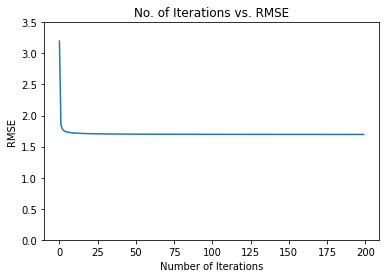

In [156]:
print('RMSError of rated movies: ', get_error(A, X, Y, W))
plt.figure()
plt.plot(errors)
plt.ylim([0, 3.5])
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('No. of Iterations vs. RMSE')
plt.show()

Once the number of iterations has finished, we will get updated X and Y matrices, which
will be utilized to create the entire predicted ratings matrix, which can be obtained from a
simple dot product, as follows:

In [157]:
A_hat = np.dot(X, Y)

After calculating the predicted matrix (A_hat), the next and final task is to utilize it to
recommend the most relevant movies to users. In the following code, we recommend
movies to any particular user based on their movie review patterns or ratings provided:

In [158]:
def print_recommovies(uid=315, n_movies=15, pred_mat=A_hat, wpred_mat=W_pred):
    pred_recos = pred_mat * wpred_mat
    pd_predrecos = pd.DataFrame(pred_recos, index=rp.index, columns=rp.columns)
    pred_ratings = pd_predrecos.loc[uid,:].sort_values(ascending=False)
    pred_topratings = pred_ratings[:n_movies,]
    pred_topratings = pred_topratings.rename('pred_ratings')
    pred_topratings = pd.DataFrame(pred_topratings)
    pred_topratings['index1'] = pred_topratings.index
    pred_topratings['index1'] = pred_topratings['index1'].astype('int64')
    pred_topratings = pd.merge(pred_topratings, movies[['movieId', 'title']], how='left', left_on='index1',
                              right_on='movieId')
    del pred_topratings['index1']
    print('\nTop', n_movies, 'movies predicted for the user:', uid, ' based on collaborative filtering\n')
    return pred_topratings

predmtrx = print_recommovies(uid=355, n_movies=10, pred_mat=A_hat, wpred_mat=W_pred)
print(predmtrx)


Top 10 movies predicted for the user: 355  based on collaborative filtering

   pred_ratings  movieId                                title
0      2.814084     1213                    Goodfellas (1990)
1      2.396029     1197           Princess Bride, The (1987)
2      2.388550     1923  There's Something About Mary (1998)
3      2.272392     2987      Who Framed Roger Rabbit? (1988)
4      2.087558     5010               Black Hawk Down (2001)
5      2.051411     5903                   Equilibrium (2002)
6      1.955899     8798                    Collateral (2004)
7      1.918850     8622               Fahrenheit 9/11 (2004)
8      1.841540     1298          Pink Floyd: The Wall (1982)
9      1.790842     8957                           Saw (2004)


From the previous recommendations, we can see that the movie user 355 might like most is
Goodfellas, followed by Princess Bride, There's Something About Mary, and so
on. Well, these recommendations need to be judged by the user himself!

### Grid search on collaborative filtering

As we mentioned earlier, we need to tune the parameters in order to see where we will get
the best possible machine learning model. Tuning the parameters is a kind of de-facto
standard in any machine learning model. In the following code, we have tried various
combinations for number of iterations, latent factors, and learning rate. The entire code will
remain more or less the same, but we always keep a tab on the least minimum errors we
have seen; if any new errors comes up as less than the existing errors, we print the
combinations accordingly:

In [160]:
# Grid Search on Collaborative Filtering
niters = [20, 50, 100, 200]
factors = [30, 50, 70, 100]
lambdas = [0.001, 0.01, 0.05, 0.1]

init_error = float('inf')
print('\n\nGrid Search results of ALS Matrix Factorization:\n')
for niter in niters:
    for facts in factors:
        for lmbd in lambdas:
            X = 5 * np.random.rand(m, facts)
            Y = 5 * np.random.rand(facts, n)
            for iter in range(niter):
                X = np.linalg.solve(np.dot(Y, Y.T) + lmbda *
                                   np.eye(facts), np.dot(Y, A.T)).T
                Y = np.linalg.solve(np.dot(X.T, X) + lmbda *
                                   np.eye(facts), np.dot(X.T, A))
            error = get_error(A, X, Y, W)
            if error < init_error:
                print('No. of iters', niter, 'No. of Factors', facts, 
                     'Lambda', lmbda, 'RMSE', error)
                init_error = error



Grid Search results of ALS Matrix Factorization:

No. of iters 20 No. of Factors 30 Lambda 0.1 RMSE 2.321545343476532
No. of iters 20 No. of Factors 30 Lambda 0.1 RMSE 2.321331728550021
No. of iters 20 No. of Factors 50 Lambda 0.1 RMSE 2.106197050365968
No. of iters 20 No. of Factors 50 Lambda 0.1 RMSE 2.1060966285147638
No. of iters 20 No. of Factors 70 Lambda 0.1 RMSE 1.9318027866133833
No. of iters 20 No. of Factors 70 Lambda 0.1 RMSE 1.9316763426262076
No. of iters 20 No. of Factors 70 Lambda 0.1 RMSE 1.9314155661884542
No. of iters 20 No. of Factors 100 Lambda 0.1 RMSE 1.7081674823007502
No. of iters 20 No. of Factors 100 Lambda 0.1 RMSE 1.7074661490403047
No. of iters 50 No. of Factors 100 Lambda 0.1 RMSE 1.7004941913599483
No. of iters 50 No. of Factors 100 Lambda 0.1 RMSE 1.7002990565338432
No. of iters 100 No. of Factors 100 Lambda 0.1 RMSE 1.6972266992521148
No. of iters 200 No. of Factors 100 Lambda 0.1 RMSE 1.6960399645289455
No. of iters 200 No. of Factors 100 Lambda 0.1

The best possible RMSE value obtained from the grid search is 1.695710, which is less than
the RMSE value from the basic method, which is 1.695710. Hence, it is always advisable to
perform grid search before implementing any algorithm.

In [161]:
# References and credits to
# Statistics in Machine Learning